In [130]:
import networkx as nx 
import sys
sys.path.append('..')
import EoNlocal as EoN
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()
import quarantines as Q
import utils

In [2]:
N = 10 ** 4
G = nx.barabasi_albert_graph(N, 5)

In [142]:
""" Idea 1: want to plot (time, #infected) for all nodes"""
def get_time_numinf(G, tau, gamma, rho):
    xmission = EoN.fast_SIR(G, tau, gamma, rho=rho, return_full_data=True).transmissions()
    return xmission_pairs(xmission)
    
def xmission_pairs(xmission):
    time_infected = {} # node -> time
    num_infected = {} # node -> num_infected (int)
    for t, source, target in xmission:
        time_infected[target] = t
        num_infected[source] = num_infected.get(source, 0) + 1
    pairs = []
    for k, t in time_infected.items():
        pairs.append((t, num_infected.get(k, 0)))
    return pairs

def inc_pairlist(pairs, inc, idx):
    # Adds inc to pair[idx] for all pair in pairs 
    output = [] 
    for el in pairs:
        listed = list(el)
        listed[idx] = listed[idx] + inc 
        output.append(tuple(listed))
    return output

def lowflat(lol):
    out = [] 
    for el in lol:
        for _ in el:
            out.append(_)
    return out
    
def avg_pairs(pairlist):
    # Takes a list of pairs and return
    return tuple([np.mean(_) for _ in (zip(*pairlist))])

def smoothed_gtn(pairs, bins=100):
    # Takes the above ^ pairs of (time, #infected) and sorts by time
    # then buckets into buckets of equal size -- and returns averaging over all 
    sorted_pairs = sorted(pairs, key=lambda p: p[0])
    increment = len(sorted_pairs) // bins
    num_increment = len(sorted_pairs) // increment + 1
    avg_list = []
    for i in range(num_increment):
        avg_list.append(avg_pairs(sorted_pairs[increment * i : increment * (i + 1)]))
    return avg_list

def get_time_numinf_quarantine(G, tau, gamma, rho, qprops):
    summaries = Q.quarantine_by_prop(G, tau, gamma, rho, qprops, float('inf'), return_summary=True)[1]
    pairs = [xmission_pairs(_.transmissions()) for _ in summaries]
    inc_pairs = [pairs[0]]
    maxt = 0
    for idx, summary in enumerate(summaries[:-1]):
        maxt += summary.t()[-1]
        pairs[idx + 1] = inc_pairlist(pairs[idx+1], maxt, 0)
    return pairs


def smooth_multi_gtn(pairs, bins=100):
    # makes 100 bins total, but separates into different buckets based on each 
    # first figure out how many buckets per 'pairsList'
    lens = [len(_) for _ in pairs] 
    total = sum(lens)
    bins_per_list = [int(_ / total * bins) for _ in lens]
    output = []
    for listbins, pairlist in zip(bins_per_list, pairs):
        output.append(smoothed_gtn(pairlist, bins=listbins))
    return output

def ba_minus_k(N, m, k, remove=True):
    # Removes the top k% of nodes from a barabasi albert graph
    G = nx.barabasi_albert_graph(N, m)
    sorted_deg = sorted(dict(G.degree()).items(), key=lambda d: -d[1])
    remove_nodes = [_[0] for _ in sorted_deg[: int(k * N)]]
    if remove:
        G.remove_nodes_from(remove_nodes)
        return G
    return G, remove_nodes

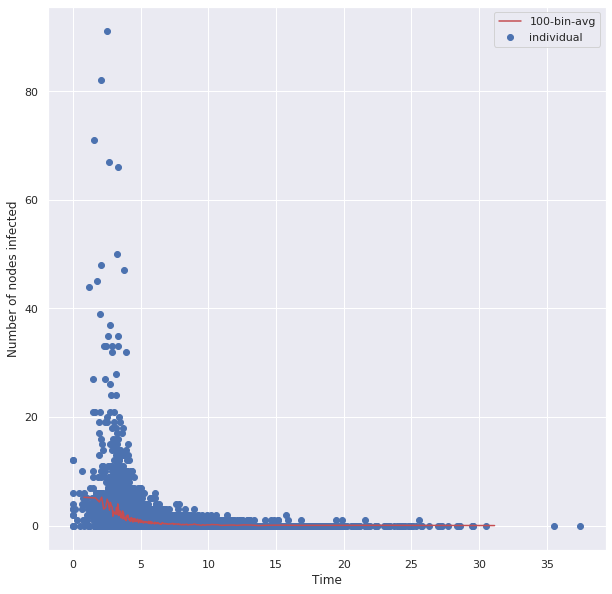

In [119]:
fig, ax = plt.subplots(figsize=(10, 10))
pairs = get_time_numinf(G, 0.1, 0.1, 10 / N)
smooth_pairs = smoothed_gtn(pairs, bins=200)
ax.scatter(*zip(*pairs), c='b', label='individual')
ax.plot(*zip(*smooth_pairs), c='r', label='100-bin-avg')
ax.set_ylabel("Number of nodes infected")
ax.set_xlabel("Time")
ax.legend()

Text(0.5, 0, 'Time')

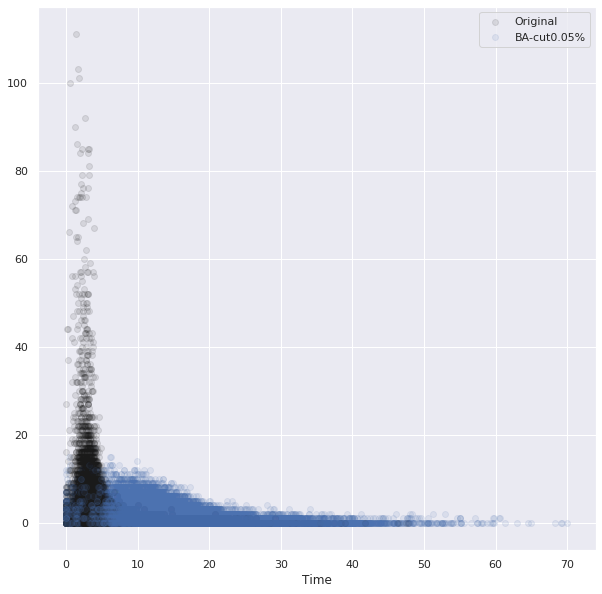

In [146]:
# Now try and plot multiple smoothings on the same plot 
fig, ax = plt.subplots(figsize=(10, 10))
G = nx.barabasi_albert_graph(N, 5)
klist = [0.05]
Gs = [ba_minus_k(N, 5, k) for k in klist]
for i in range(10):
    pairs = get_time_numinf(G, 0.1, 0.1, 10 / N)
    ax.scatter(*zip(*pairs), c=['k'], alpha=0.1, label='Original')
    
    for j, (k, lowG) in enumerate(zip(klist, Gs)):
        pairs = get_time_numinf(lowG, 0.1, 0.1, 10 / N)
        ax.scatter(*zip(*pairs), c=utils.c(j), alpha=0.1, label='BA-cut%s%%' % k)
    
    if i == 0:
        ax.legend()
ax.set_xlabel('Time')
    #ax.plot(*zip(*smooth_pairs), c='k', alpha=0.5)
